#Requirements
* /content/final_resume_dataset.csv
* /content/final_resume_dataset_with_scores.csv
* /content/nn_final_resume_dataset.csv
* /content/recommendation.zip
* /content/resume.pdf
* /content/resume_reference_analysis_results.csv




In [12]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [13]:
!pip install fitz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.9 MB/s eta 0:00:00
  Created wheel for configobj: filename=configobj-5.0.9-py2.py3-none-any.whl size=35614 sha256=467a388cedef5b09fa812b92999351d2046189cbdb26c84b264fd2b31fe2f047
  Stored in directory: /root/.cache/pip/wheels/a1/6c/03/6c5e3cf1a6e4b9e

In [14]:
!pip install PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 33.4 MB/s eta 0:00:00


In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
!pip install flask pandas nltk vaderSentiment spacy scikit-learn pdfplumber
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#For a single file score of resume calculator

In [19]:
import pandas as pd
import zipfile
import os
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import nltk
import pdfplumber

nltk.download('stopwords')

# Initialize spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Initialize Sentiment Analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score and normalize it
def overly_positive_score(text):
    sentiment = sentiment_analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    normalized_score = (compound_score + 1) / 2  # Convert from [-1, 1] to [0, 1]
    return round(normalized_score, 2)  # Return the score rounded to two decimal places

# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Return empty string if input is not a valid string

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    return ' '.join(filtered_tokens)

# Function to calculate similarity between résumé and reference letter
def calculate_similarity(resume_text, recommendation_text):
    vectorizer = TfidfVectorizer(stop_words='english')
    documents = [resume_text, recommendation_text]
    tfidf_matrix = vectorizer.fit_transform(documents)
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return cosine_sim[0][0]

# Function to extract reference letters from zip file
def extract_reference_letters(zip_file_path, extract_to='reference_letters'):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    reference_files = []
    for root, dirs, files in os.walk(extract_to):
        for file in files:
            if file.endswith('.txt'):
                reference_files.append(os.path.join(root, file))

    return reference_files

# Function to safely read text files with encoding fallback
def safe_read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        try:
            with open(file_path, 'r', encoding='ISO-8859-1') as file:
                return file.read()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return ""

# Function to analyze a single résumé against multiple reference letters
def analyze_resume_with_references(resume_file_path, reference_files):
    resume_text = safe_read_file(resume_file_path)
    preprocessed_resume = preprocess_text(resume_text)

    analysis_results = []

    for reference_file in reference_files:
        reference_text = safe_read_file(reference_file)
        preprocessed_reference = preprocess_text(reference_text)

        sentiment_score = overly_positive_score(preprocessed_reference)
        similarity_score = calculate_similarity(preprocessed_resume, preprocessed_reference)

        analysis_results.append({
            'Resume_File': resume_file_path,
            'Reference_File': reference_file,
            'Sentiment_Score': sentiment_score,
            'Similarity_Score': similarity_score
        })

    return analysis_results

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text

    cleaned_text = preprocess_text(text)
    return cleaned_text

# Function to extract experience from résumé
def extract_experience(text):
    year_pattern = r'\b(?:\d{1,2}/)?(19|20)\d{2}\b'
    dates = [match.group() for match in re.finditer(year_pattern, text)]
    years = []

    for date in dates:
        if re.match(r'\b\d{1,2}/(19|20)\d{2}\b', date):
            year = date.split('/')[1]
            years.append(year)
        elif re.match(r'\b(19|20)\d{2}\b', date):
            years.append(date)

    if years:  # Ensure there are years extracted
        experience = int(max(years)) - int(min(years))
        return experience
    return 0  # Return 0 if no years found

# Example usage
resume_file_path = '/content/resume.pdf'
zip_file_path = '/content/recommendation.zip'

# Extract reference letters
reference_files = extract_reference_letters(zip_file_path)

if not reference_files:
    print("No reference letters found in the zip file.")
else:
    results = analyze_resume_with_references(resume_file_path, reference_files)

    df_results = pd.DataFrame(results)

    avg_sentiment_score = df_results['Sentiment_Score'].mean()
    avg_similarity_score = df_results['Similarity_Score'].mean()

    avg_results = pd.DataFrame([{
        'Resume_File': 'Average',
        'Reference_File': 'Average',
        'Sentiment_Score': avg_sentiment_score,
        'Similarity_Score': avg_similarity_score
    }])

    df_results = pd.concat([df_results, avg_results], ignore_index=True)

    # Extract experience from the résumé
    text = extract_text_from_pdf(resume_file_path)
    experience = extract_experience(text)

    # Save the results to a CSV file
    df_results.to_csv('resume_reference_analysis_results.csv', index=False)

    # Display the results
    print(df_results)
    print(f"Average Sentiment Score: {avg_sentiment_score:.2f}")
    print(f"Average Similarity Score: {avg_similarity_score:.2f}")
    print(f"Experience: {experience} years")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              Resume_File                                     Reference_File  \
0     /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
1     /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
2     /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
3     /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
4     /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
...                   ...                                                ...   
3081  /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
3082  /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
3083  /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
3084  /content/resume.pdf  reference_letters/Recommendation_Letters_of_ID...   
3085              Average                                            Average   

      Sentiment_Score  Similarity_Score

#Years of experience extractor

In [20]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import spacy

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Initialize spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text (convert to lowercase, remove punctuation, etc.)
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Function to extract job positions from text based on common job title keywords
def extract_job_positions(text):
    # Define a list of common job-related keywords (you can extend this list)
    job_keywords = ['manager', 'supervisor', 'consultant', 'engineer', 'lecturer', 'developer',
                    'instructor', 'trainer', 'director', 'specialist', 'officer', 'analyst', 'assistant']

    sentences = sent_tokenize(text)
    job_positions = []

    for sentence in sentences:
        for word in job_keywords:
            if word in sentence.lower():
                job_positions.append(sentence)
                break

    return job_positions

# Function to extract the years of experience based on common patterns
def extract_years_of_experience(text):
    # Regex pattern to extract years like "2010 - 2015" or "2005 to 2021"
    year_pattern = r'(\b(19|20)\d{2}\b)[^\d]*(\b(19|20)\d{2}\b)?'
    matches = re.findall(year_pattern, text)

    years = []
    for match in matches:
        start_year = match[0]
        end_year = match[2] if match[2] else "Present"
        years.append((start_year, end_year))

    return years

# Function to extract proper nouns using spaCy NER
def extract_proper_nouns(text):
    doc = nlp(text)
    proper_nouns = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON']]
    return proper_nouns

# Function to analyze résumé data and create a DataFrame
def analyze_resume_data(df):
    results = []  # List to hold results for each résumé

    for index, row in df.iterrows():
        resume_text = row['Resume_Text']
        # Extract job positions
        job_positions = extract_job_positions(resume_text)

        # Extract years of experience
        years_of_experience = extract_years_of_experience(resume_text)

        # Extract proper nouns
        proper_nouns = extract_proper_nouns(resume_text)

        # Append the results
        results.append({
            'ID': row['ID'],
            'Job Positions': job_positions,
            'Years of Experience': years_of_experience,
            'Proper Nouns': proper_nouns
        })

    # Create a new DataFrame from the results
    results_df = pd.DataFrame(results)
    return results_df

# Load your CSV file (replace with your actual file path)
csv_file = 'final_resume_dataset.csv'
df = pd.read_csv(csv_file)

# Run the résumé analysis and get the new DataFrame
analysis_df = analyze_resume_data(df)

# Display the analysis DataFrame
print(analysis_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      ID                                      Job Positions  \
0    649  [Education and Training Prairie State Jr. Coll...   
1    160                                                 []   
2    369  [DIRECTOR OF INFORMATION TECHNOLOGY Executive ...   
3    742  [Supervised/engaged in outing (field trips) th...   
4    465  [INFORMATION TECHNOLOGY SPECIALIST Summary Sec...   
..   ...                                                ...   
995  248  [INFORMATION TECHNOLOGY SPECIALIST Career Over...   
996  393  [MARKETING AND CORPORATE COMMUNICATIONS MERCHA...   
997  293  [DANCE INSTRUCTOR Summary Enthusiastic dance i...   
998  531  [FINANCE MANAGER Accomplishments Transfer Pric...   
999  516  [ASSISTANT DIRECTOR OF FINANCE Professional Ov...   

                                   Years of Experience  \
0    [(2012, 2014), (2014, 2014), (2014, 2015), (20...   
1    [(2016, Present), (2014, Present), (2015, Pres...   
2    [(2000, Present), (2014, Present), (1998, Pres...   
3          

#Resume score giver for one resume and recommendation

In [21]:
import pdfplumber
import re
import zipfile
import os
import pandas as pd
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text).strip()  # Remove multiple spaces and newlines
    return text

def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
    return preprocess_text(text)

def extract_recommendation_letters(zip_path, extract_dir="recommendation_letters"):
    texts = []
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        for root, dirs, files in os.walk(extract_dir):
            for file in files:
                if file.endswith('.pdf'):  # Adjusted to PDF files
                    file_path = os.path.join(root, file)
                    texts.append(extract_text_from_pdf(file_path))
    except Exception as e:
        print(f"Error unzipping or extracting recommendation letters: {e}")
    return texts

def extract_job_count(resume_text):
    job_pattern = r'(?i)(Company Name.*?)(?=,\s*|\n|$)'
    job_titles = re.findall(job_pattern, resume_text)
    return len(job_titles)

def count_adjectives(text):
    if pd.isnull(text):
        return 0
    doc = nlp(str(text))
    return sum(1 for token in doc if token.pos_ == 'ADJ')

def count_degrees(text):
    degree_keywords = [r'\bBachelor\b', r"\bBachelor's\b", r'\bBachelors\b', r'\bMaster\b', r"\bMaster's\b", r'\bMasters\b']
    if pd.isnull(text):
        return 0
    return sum(len(re.findall(keyword, text, re.IGNORECASE)) for keyword in degree_keywords)

def count_certificate(text):
    certificate_keywords = [r'\bCertificate\b', r'\bCertified\b']
    if pd.isnull(text):
        return 0
    return sum(len(re.findall(keyword, text, re.IGNORECASE)) for keyword in certificate_keywords)

def detect_soft_skills(text):
    text = text.lower()
    skills_found = [skill for skill in soft_skills if skill in text]
    return len(skills_found)

def detect_technical_skills(text):
    text = text.lower()
    tech_skills_found = [skill for skill in technical_skills if skill in text]
    return len(tech_skills_found)

def extract_years_of_experience_and_update_df(df, text_column):
    def extract_years(text):
        year_pattern = r'(\b(19|20)\d{2}\b)[^\d]*(\b(19|20)\d{2}\b)?'
        matches = re.findall(year_pattern, text)
        years = []
        for match in matches:
            start_year = int(match[0])
            end_year = int(match[2]) if match[2] else 2024  # Assume current year if no end year
            years.append(end_year - start_year)
        return max(years) if years else 0

    df['Years_of_Experience'] = df[text_column].apply(extract_years)
    return df

def calculate_resume_score(resume_text, recommendation_texts):
    df = pd.DataFrame({
        'Resume_Text': resume_text,
        'Recommendation_Text': recommendation_texts
    })
    df['Number_of_Jobs'] = df['Resume_Text'].apply(extract_job_count)
    df['Number_of_Adjectives'] = df['Recommendation_Text'].apply(count_adjectives)
    df['Number_of_Degrees'] = df['Resume_Text'].apply(count_degrees)
    df['Number_of_Certificates'] = df['Resume_Text'].apply(count_certificate)
    df['Technical_Skill_Count'] = df['Resume_Text'].apply(detect_technical_skills)
    df['Soft_Skill_Count'] = df['Resume_Text'].apply(detect_soft_skills)
    df = extract_years_of_experience_and_update_df(df, 'Resume_Text')

    # Define weightage for each parameter (excluding 'ID')
    weights = {
        'Years_of_Experience': 0.3,
        'Number_of_Degrees': 0.2,
        'Number_of_Adjectives': 0.15,
        'Technical_Skill_Count': 0.12,
        'Soft_Skill_Count': 0.1,
        'Number_of_Jobs': 0.08,
        'Number_of_Certificates': 0.05,
    }

    # Calculate the score for each résumé
    df['Score'] = df.apply(lambda row: sum(row[param] * weight for param, weight in weights.items()), axis=1)

    # Calculate total résumé score
    resume_score = df['Score'].sum()

    # Optionally save the DataFrame
    # df.to_csv('resume_dataset_with_score.csv', index=False)

    return resume_score, df  # Return the total score and DataFrame for further inspection


#Fraud_prediction_score_giver


In [25]:
import pandas as pd
from nltk.corpus import stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import string

# Initialize spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Initialize Sentiment Analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Expanded list of soft skills
soft_skills = [
    "communication", "teamwork", "leadership", "creativity", "work ethic", "adaptability",
    "problem solving", "time management", "critical thinking", "initiative", "interpersonal skills",
    "dependability", "motivation", "collaboration", "decision-making", "negotiation", "organization",
    "active listening", "empathy", "flexibility"
]

# Expanded list of vague terms
vague_terms = [
    "potential", "great", "enthusiastic", "excellent", "amazing", "incredible", "hardworking",
    "outstanding", "passionate", "energetic", "dedicated", "efficient", "effective", "highly skilled",
    "competent", "reliable", "focused", "resourceful", "goal-oriented"
]

# Function to calculate sentiment score and normalize it
def overly_positive_score(text):
    sentiment = sentiment_analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    # Scale the score to a value between 0 and 1
    normalized_score = (compound_score + 1) / 2  # Convert from [-1, 1] to [0, 1]
    return round(normalized_score, 2)  # Return the score rounded to two decimal places

# Function to preprocess text (convert to lowercase, remove punctuation, stopwords, etc.)
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Return empty string if input is not a valid string

    # Step 1: Convert to lowercase
    text = text.lower()

    # Step 2: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 4: Tokenization and stopword removal (consider only alphabetic words)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    return ' '.join(filtered_tokens)

# Function to detect vague language using TF-IDF
def specificity_analysis(text):
    # Check if the text is empty or None
    if not text or text.strip() == "":
        return 0  # Return 0 if there is no recommendation letter or the text is empty

    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()

    # Sum the tf-idf values for vague terms in the input text
    vague_score = 0
    for term in vague_terms:
        if term in feature_names:
            idx = vectorizer.vocabulary_.get(term, -1)
            if idx != -1:
                vague_score += tfidf_matrix[0, idx]  # First document is our input text

    return vague_score

# Function to detect soft skills mentioned without examples
def detect_soft_skills(text):
    text = text.lower()
    skills_found = [skill for skill in soft_skills if skill in text]

    # Count how many soft skills are found
    return len(skills_found), skills_found

# Function to analyze Named Entities (specific achievements or people mentioned)
def entity_specificity_analysis(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'DATE', 'GPA']]

    # Return the number of entities and the list
    return len(entities), entities

# Function to calculate similarity between résumé and recommendation letter
def calculate_similarity(resume_text, recommendation_text):
    vectorizer = TfidfVectorizer(stop_words='english')

    # Combine both documents
    documents = [resume_text, recommendation_text]

    # Vectorize the text
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Compute cosine similarity between the résumé and the recommendation letter
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

    return cosine_sim[0][0]  # Returns the similarity score

# Function to flag exaggerated claims and check résumé-letter similarity, store results in a DataFrame
def analyze_exaggeration_with_similarity(df):
    # Preprocess text columns in the DataFrame
    df['Preprocessed_Resume_Text'] = df['Resume_Text'].apply(preprocess_text)
    df['Preprocessed_Recommendation_Text'] = df['Recommendation_Text'].apply(preprocess_text)

    # Create new columns to store the scores
    df['Sentiment_Score'] = 0.0
    df['Vague_Term_Score'] = 0.0
    df['Soft_Skill_Count'] = 0
    df['Soft_Skills_Detected'] = ""
    df['Entity_Count'] = 0
    df['Entities_Detected'] = ""
    df['Similarity_Score'] = 0.0
    df['Exaggeration_Flag'] = False
    df['Similarity_Flag'] = False

    for index, row in df.iterrows():
        resume_text = row['Preprocessed_Resume_Text']
        recommendation_text = row['Preprocessed_Recommendation_Text']

        # Sentiment Analysis
        sentiment_score = overly_positive_score(recommendation_text)
        df.at[index, 'Sentiment_Score'] = sentiment_score

        # Specificity Analysis
        vague_score = specificity_analysis(recommendation_text)
        df.at[index, 'Vague_Term_Score'] = vague_score

        # Soft Skill Detection
        soft_skill_count, soft_skills_detected = detect_soft_skills(recommendation_text)
        df.at[index, 'Soft_Skill_Count'] = soft_skill_count
        df.at[index, 'Soft_Skills_Detected'] = ', '.join(soft_skills_detected)

        # Entity Specificity
        entity_count, entities_detected = entity_specificity_analysis(recommendation_text)
        df.at[index, 'Entity_Count'] = entity_count
        df.at[index, 'Entities_Detected'] = ', '.join(entities_detected)

        # Calculate similarity between résumé and recommendation letter
        similarity_score = calculate_similarity(resume_text, recommendation_text)
        df.at[index, 'Similarity_Score'] = similarity_score

        # Flag if exaggeration or suspicious similarity is detected
        exaggeration_flag = (sentiment_score > 0.5 and vague_score > 0.1) or soft_skill_count > entity_count
        similarity_flag = similarity_score > 0.7  # Flag if similarity is above threshold

        df.at[index, 'Exaggeration_Flag'] = exaggeration_flag
        df.at[index, 'Similarity_Flag'] = similarity_flag

    return df

# Load CSV file
csv_file = 'final_resume_dataset.csv'  # Replace with your file path
df = pd.read_csv(csv_file)

# Run the exaggeration and similarity analysis on the DataFrame
df_with_scores = analyze_exaggeration_with_similarity(df)


# Save the resulting DataFrame with all analysis scores to a new CSV file
df_with_scores.to_csv('final_resume_dataset_with_scores.csv', index=False)

# Display the DataFrame
df_with_scores.head()

,ID,Resume_Text,List,List_Count,Recommendation_Text,Preprocessed_Resume_Text,Preprocessed_Recommendation_Text,Sentiment_Score,Vague_Term_Score,Soft_Skill_Count,Soft_Skills_Detected,Entity_Count,Entities_Detected,Similarity_Score,Exaggeration_Flag,Similarity_Flag
0,649,INTERN Professional Summary Client Negotiation...,"[911, 320, 747]",3,"As a Court Appointed Special Advocate, I have ...",intern professional summary client negotiation...,court appointed special advocate privilege wor...,1.0,0.068160,6,"communication, leadership, critical thinking, ...",1,daily,0.239217,True,False
1,160,"BANKING Summary Hands-on, client-oriented bank...","[888, 517, 23, 374, 413, 123]",6,In my role as a Senior Commercial Business Ban...,banking summary handson clientoriented banking...,role senior commercial business banking relati...,1.0,0.152894,9,"communication, leadership, creativity, work et...",3,"daily, six years, daily",0.297699,True,False
2,369,DIRECTOR OF INFORMATION TECHNOLOGY Executive P...,"[872, 818, 421]",3,Having worked in the financial services indust...,director information technology executive prof...,worked financial services industry decade plea...,1.0,0.067003,4,"leadership, initiative, collaboration, organiz...",2,"annually, five years",0.302319,True,False
3,742,ABA THERAPIST Summary Team-oriented Applied Be...,"[347, 999, 744, 728, 574, 880]",6,I am pleased to recommend an outstanding indiv...,aba therapist summary teamoriented applied beh...,pleased recommend outstanding individual shown...,1.0,0.249405,8,"communication, teamwork, leadership, initiativ...",3,"years, aba therapist wholeheartedly, aba thera...",0.179954,True,False
4,465,INFORMATION TECHNOLOGY SPECIALIST Summary Secu...,"[886, 314]",2,I wholeheartedly recommend the Information Tec...,information technology specialist summary secu...,wholeheartedly recommend information technolog...,1.0,0.083844,4,"communication, leadership, initiative, organiz...",1,wholeheartedly recommend information technology,0.274877,True,False


In [26]:
# prompt: make a separate dataframe of coloumn of setiment score,vague term score,soft skill count,technical skill count,similarity score with id as 1st column

new_df = df_with_scores[['ID', 'Sentiment_Score', 'Vague_Term_Score', 'Soft_Skill_Count', 'Similarity_Score']]
print(new_df)


      ID  Sentiment_Score  Vague_Term_Score  Soft_Skill_Count  \
0    649             1.00          0.068160                 6   
1    160             1.00          0.152894                 9   
2    369             1.00          0.067003                 4   
3    742             1.00          0.249405                 8   
4    465             1.00          0.083844                 4   
..   ...              ...               ...               ...   
995  248             1.00          0.195180                 5   
996  393             1.00          0.051830                 6   
997  293             1.00          0.103591                 6   
998  531             0.99          0.129914                 2   
999  516             1.00          0.047850                 7   

     Similarity_Score  
0            0.239217  
1            0.297699  
2            0.302319  
3            0.179954  
4            0.274877  
..                ...  
995          0.354280  
996          0.424885  
997

In [ ]:
# prompt: for getting the score from give max weight to experience then number of degrees then adjectives then technical skills then soft skills then number of jobs then number of certificates and the weights assigned should be normalised get this into a new column these are the column names respectively Number_of_Jobs', 'Number_of_Adjectives', 'Number_of_Degrees',
#        'Number_of_Certificates', 'Years_of

def calculate_weighted_score(row):
  """Calculates a weighted score based on the provided criteria."""

  weights = {
      'Years_of_Experience': 0.3,  # Highest weight
      'Number_of_Degrees': 0.2,
      'Number_of_Adjectives': 0.15,
      'Technical_Skill_Count': 0.12,
      'Soft_Skill_Count': 0.1,
      'Number_of_Jobs': 0.08,
      'Number_of_Certificates': 0.05,
  }

  score = 0
  for column, weight in weights.items():
    if column in row:  # Check if the column exists in the row
      score += row[column] * weight

  return score


# Apply the function to create the new column
df1['Weighted_Score'] = df1.apply(calculate_weighted_score, axis=1)

# Display the updated DataFrame with the new column
print(df1.head())


#Resume dataset score calculator

In [28]:
# prompt: read data df1 from this /content/new_resume_dataset1.csv

import pandas as pd

# Read the CSV file into a DataFrame
df1 = pd.read_csv('/content/nn_final_resume_dataset.csv')

# You can now work with the df1 DataFrame
print(df1.head())

    ID  Number_of_Jobs  Number_of_Adjectives  Number_of_Degrees  \
0  649               3                    43                  1   
1  160               4                   102                  2   
2  369               4                    52                  0   
3  742               2                   106                  1   
4  465               3                    37                  0   

   Number_of_Certificates  Years_of_Experience  Soft skill count  \
0                       0                   12                 6   
1                       0                   12                 9   
2                       1                   38                 4   
3                       4                    3                 8   
4                       3                   15                 4   

   Technical skill count  
0                      1  
1                      3  
2                      1  
3                      0  
4                      4  


In [29]:
# prompt: for getting the score from give max weight to experience then number of degrees then adjectives then technical skills then soft skills then number of jobs then number of certificates and the weights assigned should be normalised get this into a new column these are the column names respectively Number_of_Jobs', 'Number_of_Adjectives', 'Number_of_Degrees',
#        'Number_of_Certificates', 'Years_of

def calculate_weighted_score(row):
  """Calculates a weighted score based on the provided criteria."""

  weights = {
      'Years_of_Experience': 0.3,  # Highest weight
      'Number_of_Degrees': 0.2,
      'Number_of_Adjectives': 0.15,
      'Technical_Skill_Count': 0.12,
      'Soft_Skill_Count': 0.1,
      'Number_of_Jobs': 0.08,
      'Number_of_Certificates': 0.05,
  }

  score = 0
  for column, weight in weights.items():
    if column in row:  # Check if the column exists in the row
      score += row[column] * weight

  return score


# Apply the function to create the new column
df1['Weighted_Score'] = df1.apply(calculate_weighted_score, axis=1)

# Display the updated DataFrame with the new column
print(df1.head())


    ID  Number_of_Jobs  Number_of_Adjectives  Number_of_Degrees  \
0  649               3                    43                  1   
1  160               4                   102                  2   
2  369               4                    52                  0   
3  742               2                   106                  1   
4  465               3                    37                  0   

   Number_of_Certificates  Years_of_Experience  Soft skill count  \
0                       0                   12                 6   
1                       0                   12                 9   
2                       1                   38                 4   
3                       4                    3                 8   
4                       3                   15                 4   

   Technical skill count  Weighted_Score  
0                      1           10.49  
1                      3           19.62  
2                      1           19.57  
3               

#Fraud Calculator

In [32]:
import pandas as pd

# Assuming df_with_scores is your DataFrame with the relevant columns

def calculate_fraud_score(row):
    soft_skill_weight = 4/10
    technical_skill_weight = 1/10
    similarity_weight = 5/10
    vague_term_weight = 3/10
    combined_skills_weight = 2/5

    soft_skill_score = row['Soft_Skill_Count'] * soft_skill_weight
    similarity_score = row['Similarity_Score'] * similarity_weight
    vague_term_score = row['Vague_Term_Score'] * vague_term_weight
    combined_skills_score = (row['Soft_Skill_Count'] ) * combined_skills_weight

    fraud_score = similarity_score + vague_term_score + combined_skills_score + soft_skill_score

    return fraud_score

# Apply the function to calculate the fraud score for each row in your DataFrame
df_with_scores['Fraud_Score'] = df_with_scores.apply(calculate_fraud_score, axis=1)

# Calculate mean and standard deviation of the fraud scores
mean_fraud_score = df_with_scores['Fraud_Score'].mean()
std_dev_fraud_score = df_with_scores['Fraud_Score'].std()

# Function to categorize fraud score based on standard deviations
def categorize_fraud_score(score):
    if score < (mean_fraud_score - std_dev_fraud_score):
        return 0
    elif (mean_fraud_score - std_dev_fraud_score) <= score <= (mean_fraud_score + std_dev_fraud_score):
        return 1
    else:
        return 2

# Apply categorization to the fraud score
df_with_scores['Fraud_Score_Category'] = df_with_scores['Fraud_Score'].apply(categorize_fraud_score)

# Display the updated DataFrame with the fraud score category
print(df_with_scores[['ID', 'Fraud_Score', 'Fraud_Score_Category']])


      ID  Fraud_Score  Fraud_Score_Category
0    649     4.940057                     1
1    160     7.394718                     2
2    369     3.371260                     1
3    742     6.564799                     2
4    465     3.362592                     1
..   ...          ...                   ...
995  248     4.235694                     1
996  393     5.027991                     2
997  293     4.904071                     1
998  531     1.794162                     0
999  516     5.747760                     2

[1000 rows x 3 columns]


In [34]:
# prompt: i want to give 0 as no risk type 1 as maybe risky type 2 as risky please check them thoroughly in df['Fraud_Score_Category']

# Assuming df_with_scores is your DataFrame with the 'Fraud_Score_Category' column

def categorize_fraud_score_new(score):
    """Categorizes fraud score into 0 (no risk), 1 (maybe risky), 2 (risky)."""
    if score == 0:  # Check if the score is 0
        return "No Risk"
    elif score == 1:  # Check if the score is 1
        return "Maybe Risky"
    else:
        return "Risky"

# Apply the new categorization function to create a new column
df_with_scores['Risk_Category'] = df_with_scores['Fraud_Score_Category'].apply(categorize_fraud_score_new)

# Display the updated DataFrame with the new Risk_Category column
print(df_with_scores[['ID', 'Fraud_Score', 'Fraud_Score_Category', 'Risk_Category']])


      ID  Fraud_Score  Fraud_Score_Category Risk_Category
0    649     4.940057                     1   Maybe Risky
1    160     7.394718                     2         Risky
2    369     3.371260                     1   Maybe Risky
3    742     6.564799                     2         Risky
4    465     3.362592                     1   Maybe Risky
..   ...          ...                   ...           ...
995  248     4.235694                     1   Maybe Risky
996  393     5.027991                     2         Risky
997  293     4.904071                     1   Maybe Risky
998  531     1.794162                     0       No Risk
999  516     5.747760                     2         Risky

[1000 rows x 4 columns]


#Visualization of the Fraud and Weighed resume score data


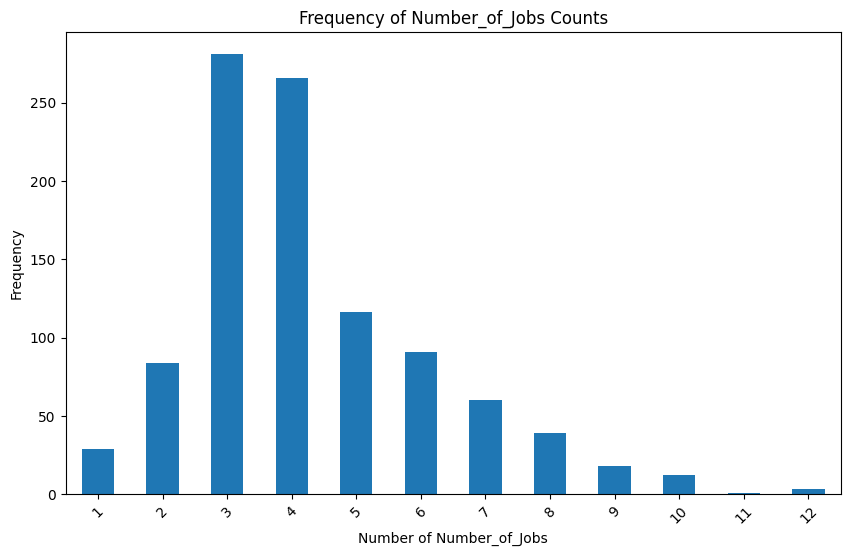

In [37]:
import matplotlib.pyplot as plt

# Create a frequency distribution of 'Technical_Skill_Count'
technical_skill_distribution = df1['Number_of_Jobs'].value_counts().sort_index()

# Plot the distribution as a bar chart
technical_skill_distribution.plot(kind='bar', figsize=(10,6))

# Set labels and title
plt.title('Frequency of Number_of_Jobs Counts')
plt.xlabel('Number of Number_of_Jobs')
plt.xticks(rotation=45)
plt.ylabel('Frequency')


# Show the plot
plt.show()


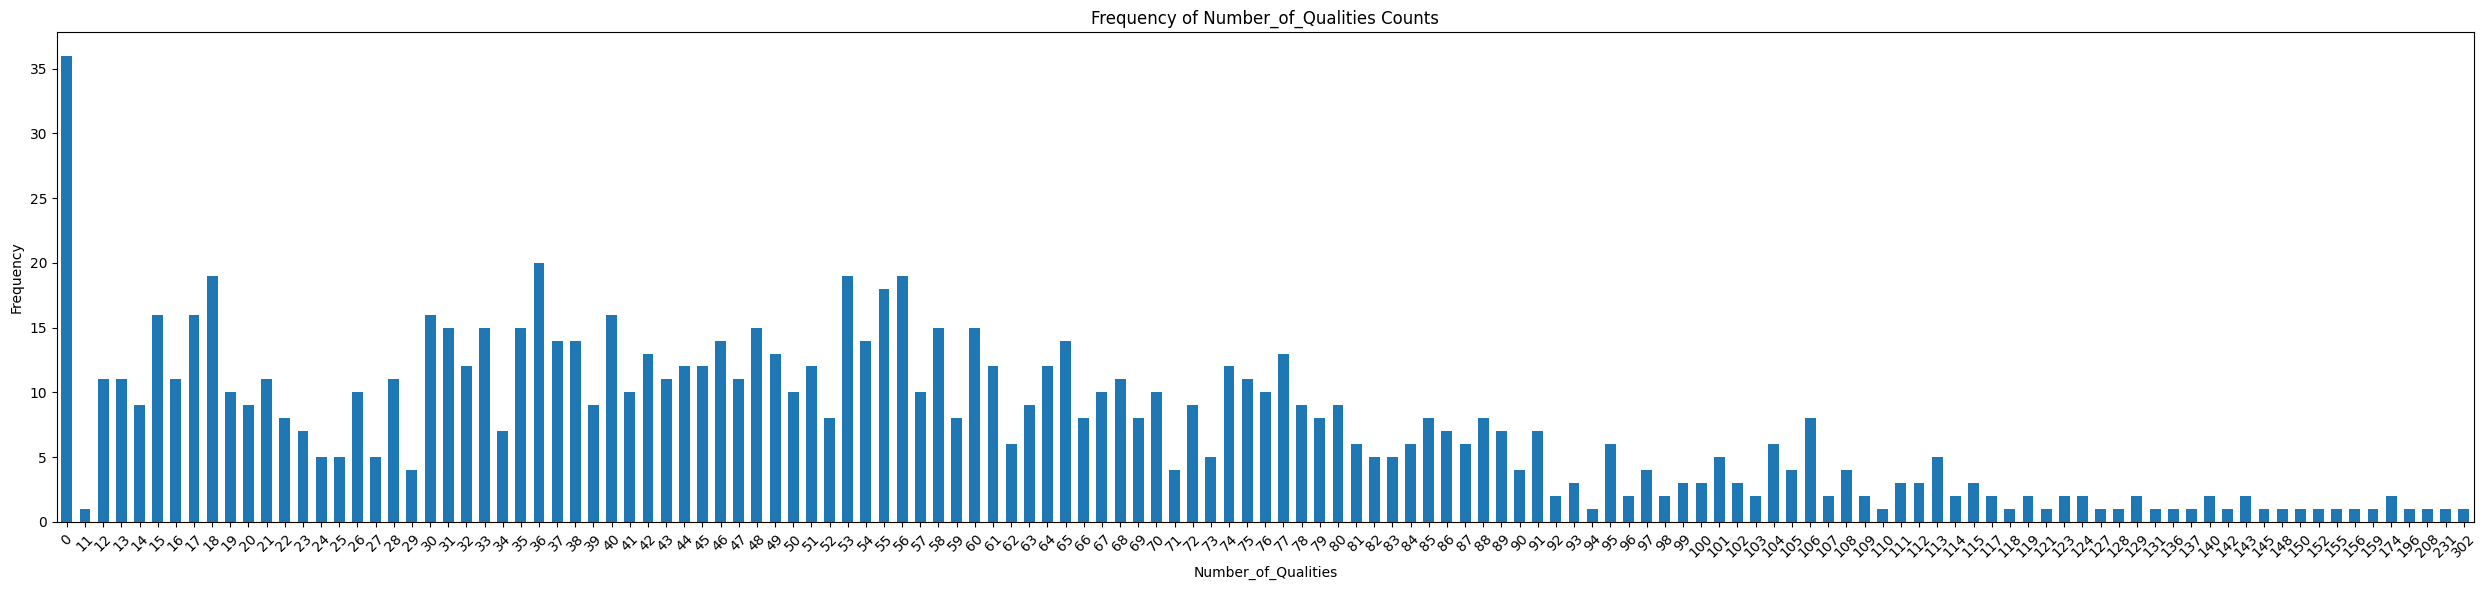

In [38]:
import matplotlib.pyplot as plt

# Create a frequency distribution of 'Number_of_Adjectives'
technical_skill_distribution = df1['Number_of_Adjectives'].value_counts().sort_index()

# Plot the distribution as a bar chart with increased bar width
technical_skill_distribution.plot(kind='bar', figsize=(25, 6), width=0.6)  # Increase the width for more gap

# Set labels and title
plt.title('Frequency of Number_of_Qualities Counts')
plt.xlabel('Number_of_Qualities')
plt.ylabel('Frequency')

# Set x-ticks to be whole numbers
plt.xticks(ticks=range(len(technical_skill_distribution.index)), labels=technical_skill_distribution.index, rotation=45)

# Show the plot
plt.tight_layout()  # Optional: adjusts the plot to fit nicely
plt.show()


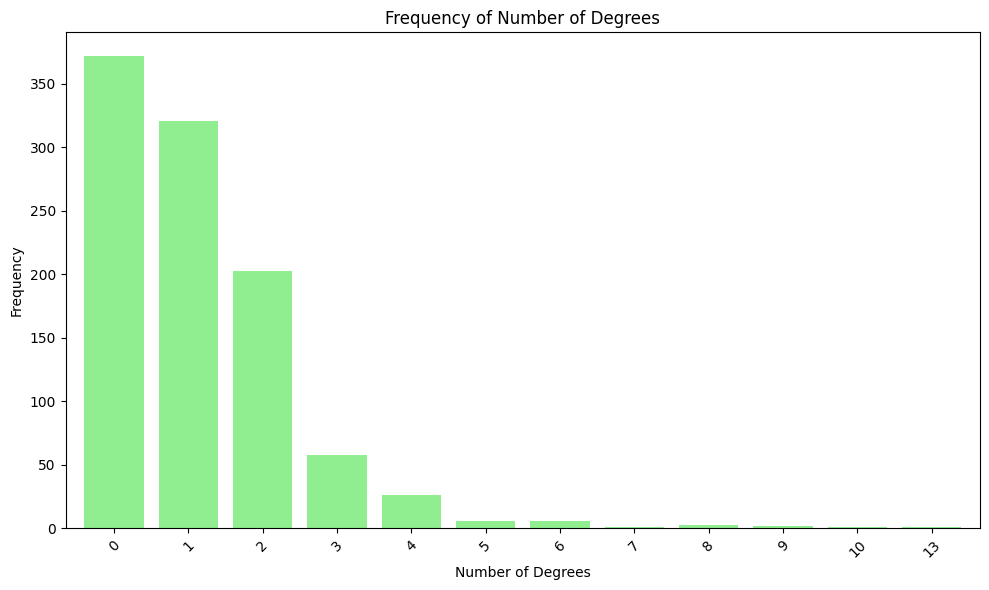

In [39]:
import matplotlib.pyplot as plt

# Create a bar graph for 'Number_of_Degrees'
plt.figure(figsize=(10, 6))
degree_distribution = df1['Number_of_Degrees'].value_counts().sort_index()
degree_distribution.plot(kind='bar', color='lightgreen', width=0.8)  # Adjust width for spacing

# Set labels and title
plt.title('Frequency of Number of Degrees')
plt.xlabel('Number of Degrees')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Horizontal x-ticks for clarity

# Show the plot
plt.tight_layout()
plt.show()


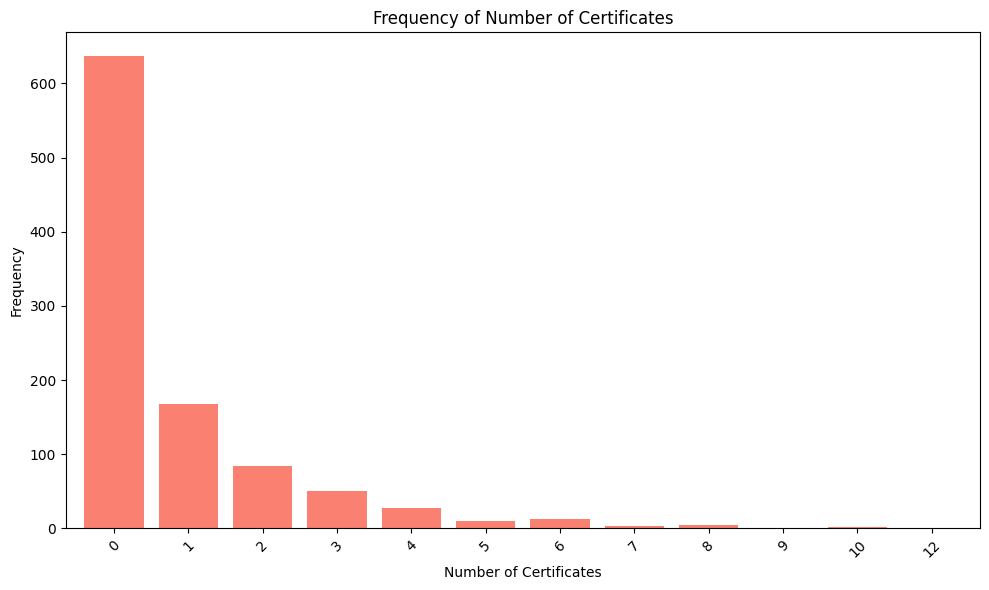

In [40]:
import matplotlib.pyplot as plt

# Create a bar graph for 'Number_of_Certificates'
plt.figure(figsize=(10, 6))
certificate_distribution = df1['Number_of_Certificates'].value_counts().sort_index()
certificate_distribution.plot(kind='bar', color='salmon', width=0.8)

# Set labels and title
plt.title('Frequency of Number of Certificates')
plt.xlabel('Number of Certificates')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


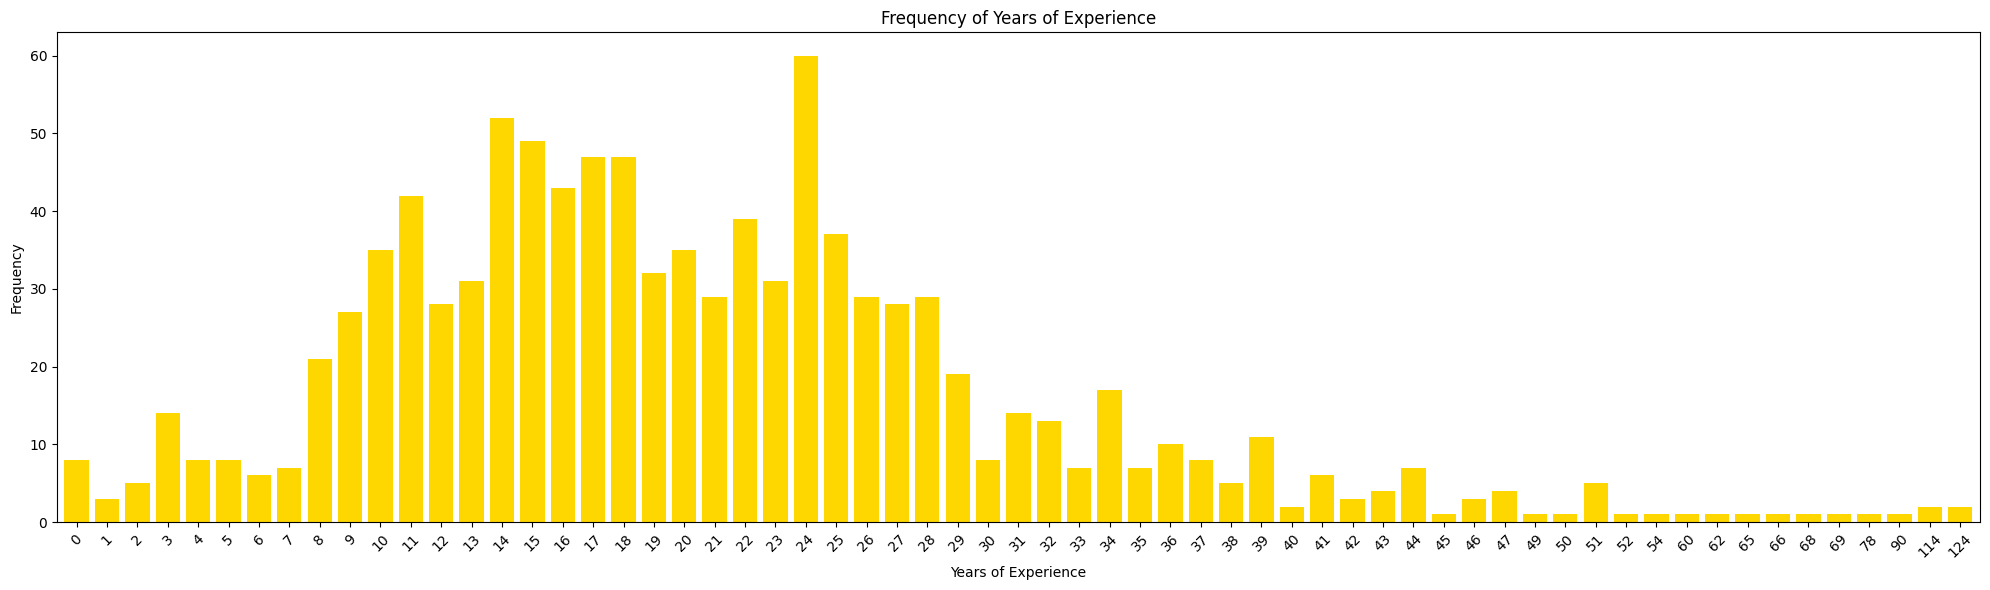

In [41]:
import matplotlib.pyplot as plt

# Create a bar graph for 'Years_of_Experience'
plt.figure(figsize=(20, 6))
experience_distribution = df1['Years_of_Experience'].value_counts().sort_index()
experience_distribution.plot(kind='bar', color='gold', width=0.8)

# Set labels and title
plt.title('Frequency of Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


#Visualization of the correlation of weighted score of resume

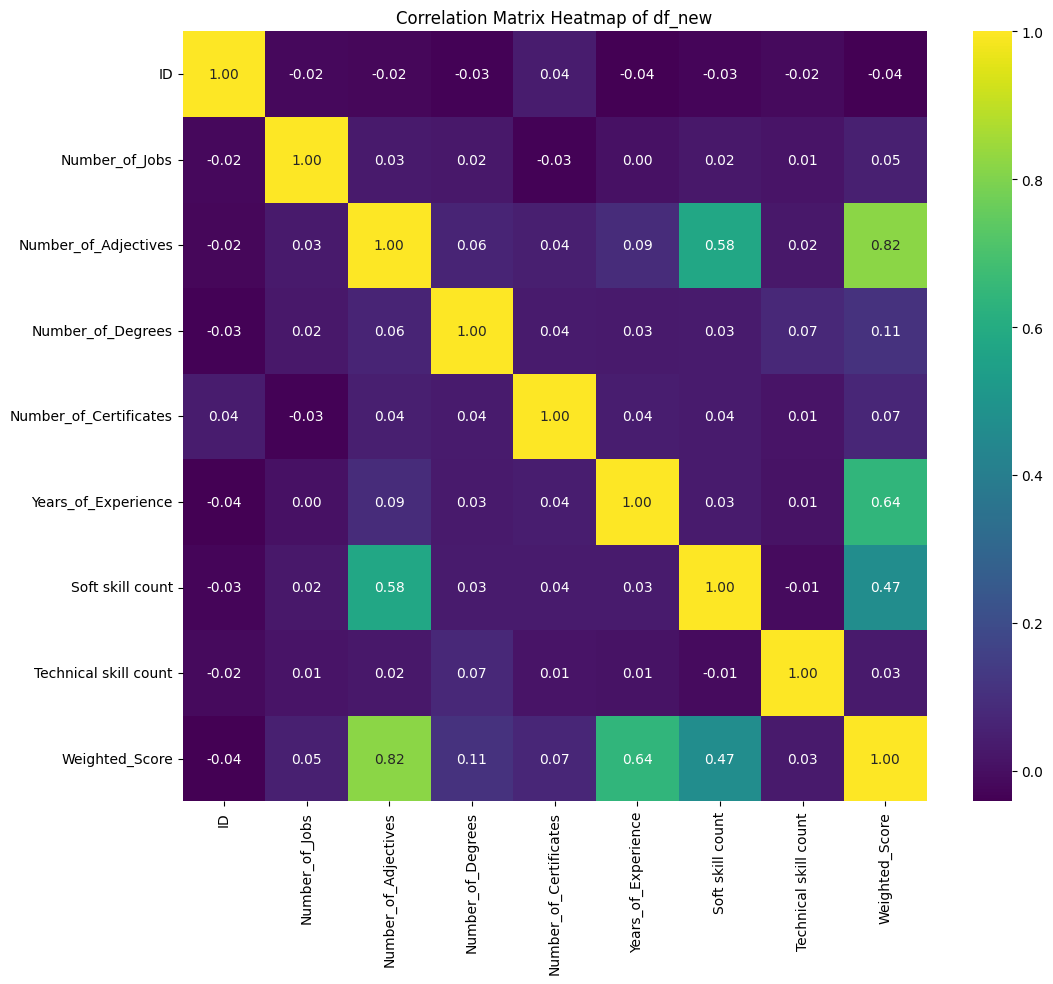

In [42]:
# prompt: give me heat_map of df_new

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_new is your DataFrame
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix Heatmap of df_new')
plt.show()


ConversionError: Failed to convert value(s) to axis units: ['1', '5', '10', '15', '20']

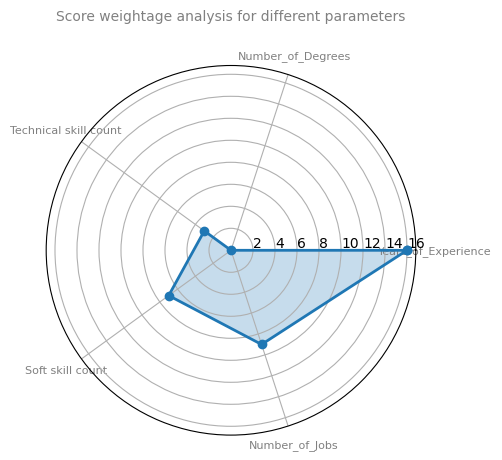

In [55]:
# prompt: generate radar graph for it

import matplotlib.pyplot as plt
import numpy as np

# Assuming df1 is your DataFrame with 'Weighted_Score' and other relevant columns

def generate_radar_chart(df, candidate_id):
  """Generates a radar chart for a specific candidate."""

  # Get the candidate's data from df1
  candidate_data = df[df['ID'] == candidate_id]

  if candidate_data.empty:
    print(f"Candidate with ID {candidate_id} not found in DataFrame.")
    return

  # Extract the relevant features (replace with your desired features)
  features = ['Years_of_Experience', 'Number_of_Degrees', 'Technical skill count', 'Soft skill count', 'Number_of_Jobs']
  values = candidate_data[features].values[0].tolist()

  # Number of variables
  categories = features
  N = len(categories)

  # Angles for radar chart
  angles = [n / float(N) * 2 * np.pi for n in range(N)]
  angles += angles[:1]

  # Values for radar chart
  values += values[:1]

  # Plot the radar chart
  ax = plt.subplot(111, polar=True)
  ax.plot(angles, values, 'o-', linewidth=2)
  ax.fill(angles, values, alpha=0.25)

  # Add labels for each axis
  plt.xticks(angles[:-1], categories, color='grey', size=8)

  # Add title and adjust settings
  plt.title(f"Score weightage analysis for different parameters", size=10, color='grey', y=1.1)
  ax.set_rlabel_position(0)
  plt.yticks(["1", "5", "10", "15", "20"], ["1", "5", "10", "15", "20"], color="grey", size=7)
  plt.ylim(0, 100)
  plt.show()


# Example: Generate radar chart for candidate with ID 1
generate_radar_chart(df1, 1)


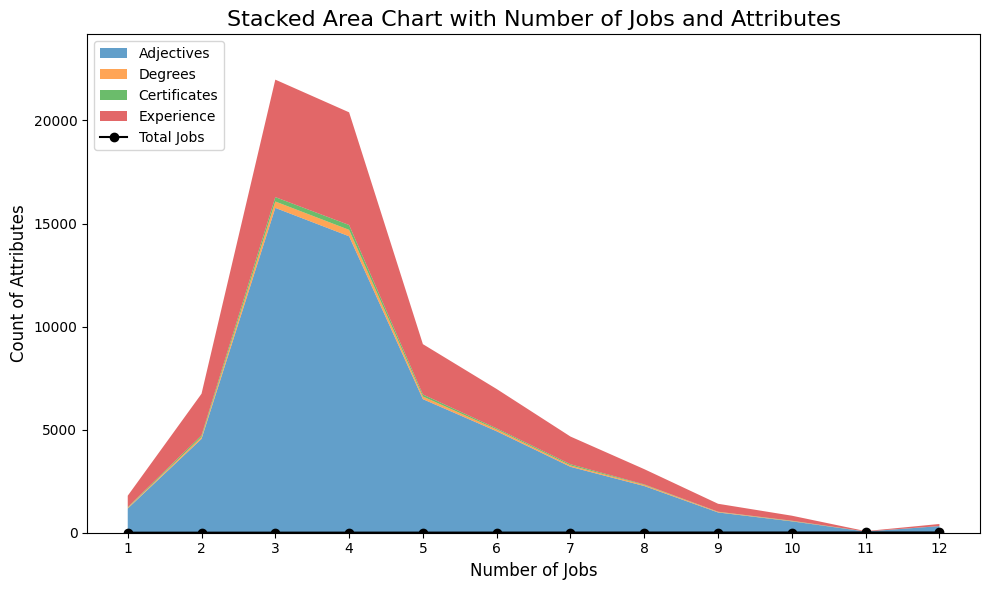

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame creation for illustration (replace this with your actual DataFrame)
# df = pd.read_csv('your_data.csv')  # Uncomment and replace with your actual data loading

# Group by number of jobs and sum other columns within the same intervals
df_grouped = df1.groupby('Number_of_Jobs').sum().reset_index()  # Reset index to make Number_of_Jobs a column

# Prepare data for the stacked area plot
# x will be the number of jobs now
x = df_grouped['Number_of_Jobs'].values  # Use the Number_of_Jobs for x-axis

# Stack the relevant columns for the area plot
y = np.vstack([
    df_grouped['Number_of_Adjectives'].values,
    df_grouped['Number_of_Degrees'].values,
    df_grouped['Number_of_Certificates'].values,
    df_grouped['Years_of_Experience'].values
])

# Create the plot
plt.figure(figsize=(10, 6))

# Stacked area plot
plt.stackplot(x, y, labels=['Adjectives', 'Degrees', 'Certificates', 'Experience'], alpha=0.7)

# Add a line plot for the number of jobs
plt.plot(x, df_grouped['Number_of_Jobs'].values, color='black', marker='o', label='Total Jobs')

# Customizing the chart
plt.title('Stacked Area Chart with Number of Jobs and Attributes', size=16)
plt.xlabel('Number of Jobs', size=12)
plt.ylabel('Count of Attributes', size=12)

# Add x-ticks and labels for the number of jobs
plt.xticks(ticks=x, labels=[str(int(job)) for job in x])  # Use the actual job numbers as labels
plt.legend(loc='upper left')

# Optionally set y-axis limits for better visibility
plt.ylim(0, np.max(y.sum(axis=0)) * 1.1)  # Adjust as needed

# Show plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


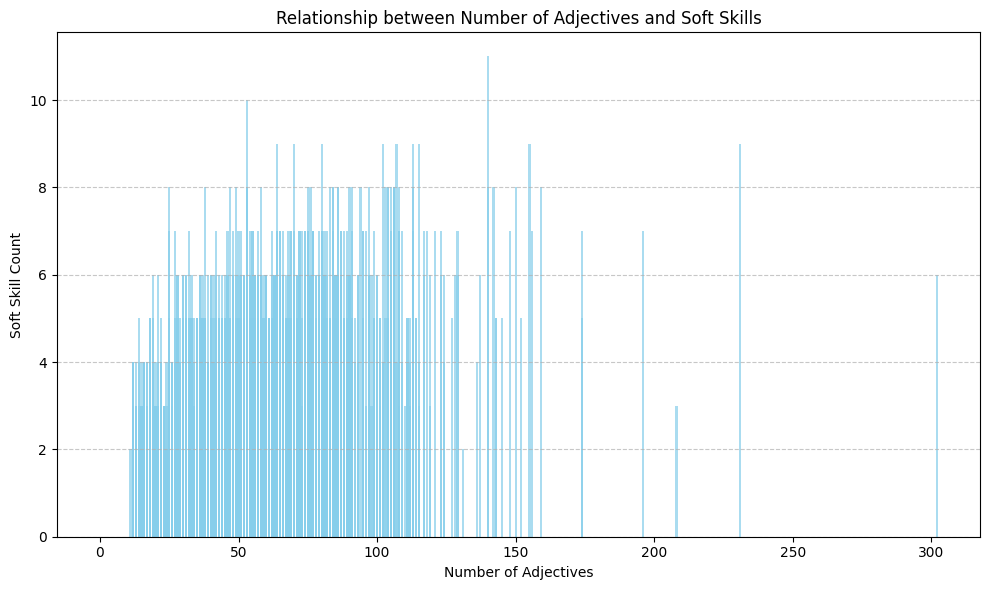

In [61]:
import matplotlib.pyplot as plt

# Assuming df1 is your DataFrame with the relevant columns

plt.figure(figsize=(10, 6))

# Create a bar graph
plt.bar(df1['Number_of_Adjectives'], df1['Soft skill count'], color='skyblue', alpha=0.7)

# Adding labels and title
plt.xlabel('Number of Adjectives')
plt.ylabel('Soft Skill Count')
plt.title('Relationship between Number of Adjectives and Soft Skills')

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


#Generating the code for fraud relations

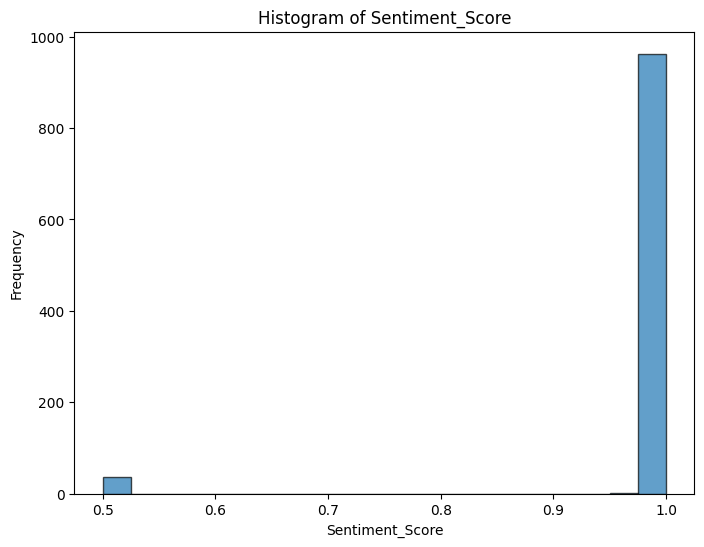

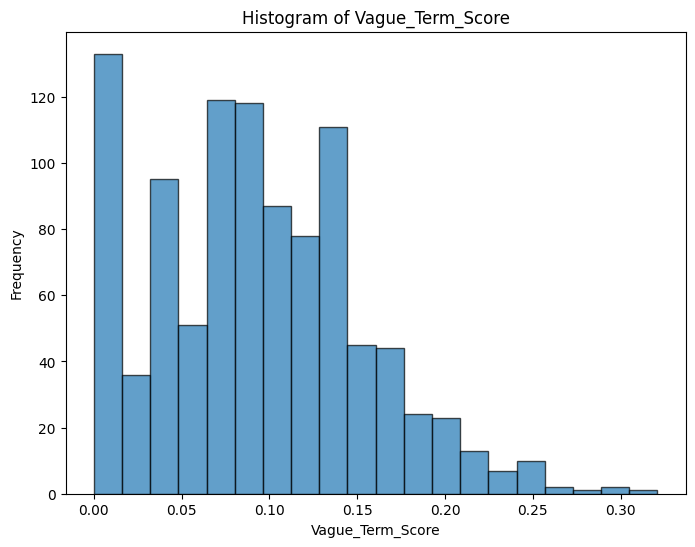

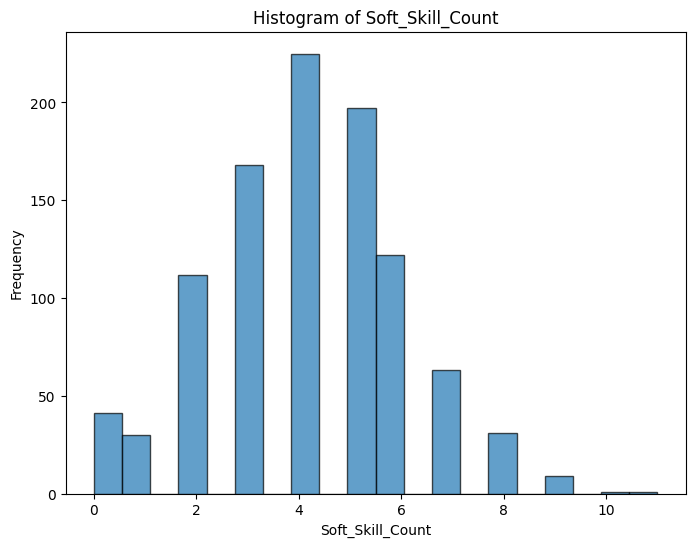

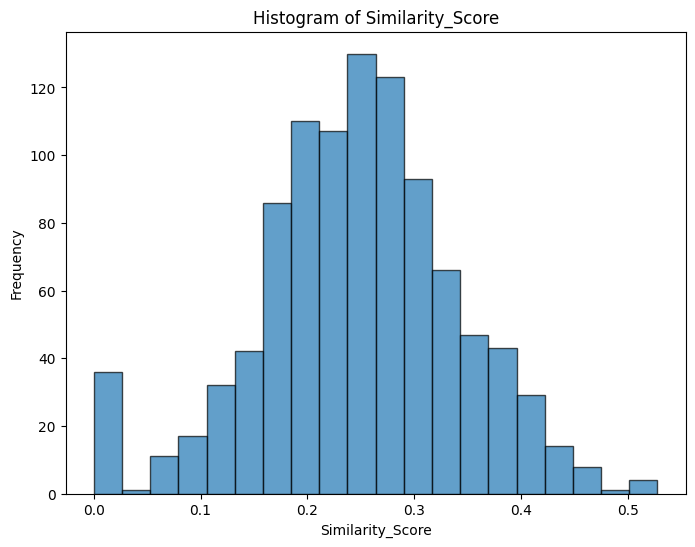

In [44]:
import matplotlib.pyplot as plt

# Iterate through columns and plot histograms
for column in new_df.columns:
    if column != 'ID':
        plt.figure(figsize=(8, 6))  # Adjust figure size as needed
        plt.hist(new_df[column], bins=20, edgecolor='black', alpha=0.7)  # Add edge color for spacing effect
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column}')
        plt.show()



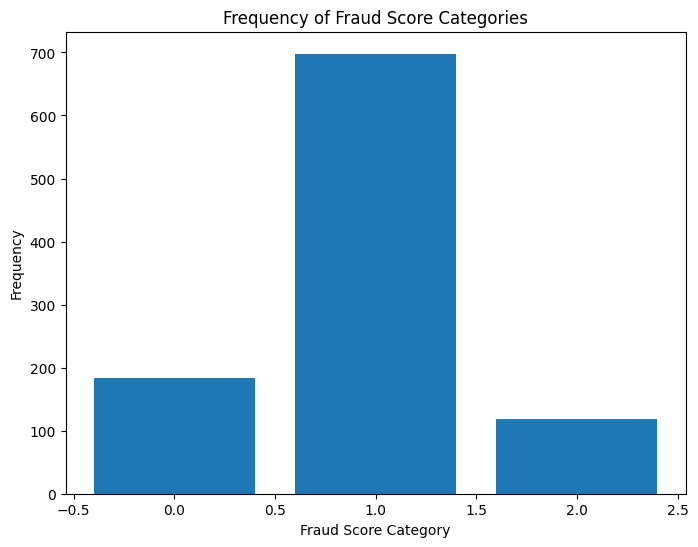

In [45]:
# prompt: generate a graph for fraud_category with frequency

import matplotlib.pyplot as plt

# Count the frequency of each fraud score category
fraud_category_counts = df_with_scores['Fraud_Score_Category'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(fraud_category_counts.index, fraud_category_counts.values)

# Set labels and title
plt.xlabel('Fraud Score Category')
plt.ylabel('Frequency')
plt.title('Frequency of Fraud Score Categories')

# Display the plot
plt.show()


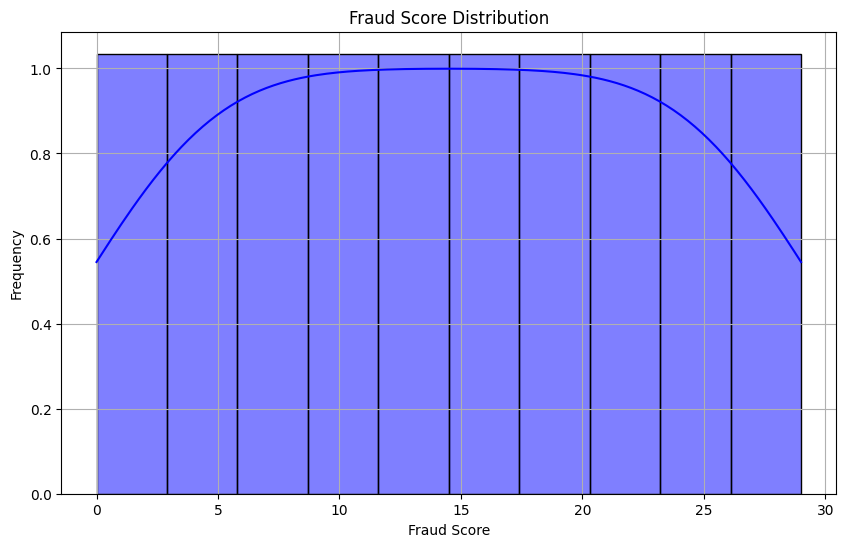

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# df = pd.read_csv('your_data.csv')  # Uncomment this line to load your data

# Sample data for demonstration
# Replace this with your actual fraud score data
data = {
    'fraud_score': range(0,30)
}
df = pd.DataFrame(data)

# Plotting the fraud score distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['fraud_score'], bins=10, kde=True, color='blue', stat='frequency')
plt.title('Fraud Score Distribution')
plt.xlabel('Fraud Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


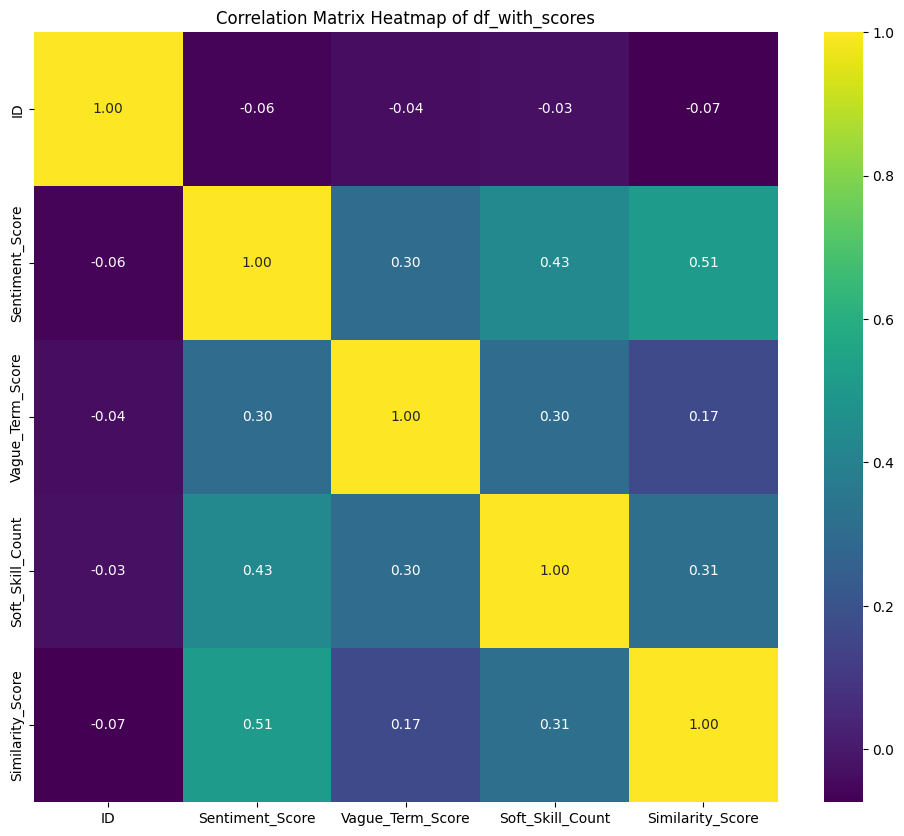

In [63]:
# prompt: heatmap of df_with_scores

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_with_scores is your DataFrame
# Calculate the correlation matrix
correlation_matrix = new_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix Heatmap of df_with_scores')
plt.show()


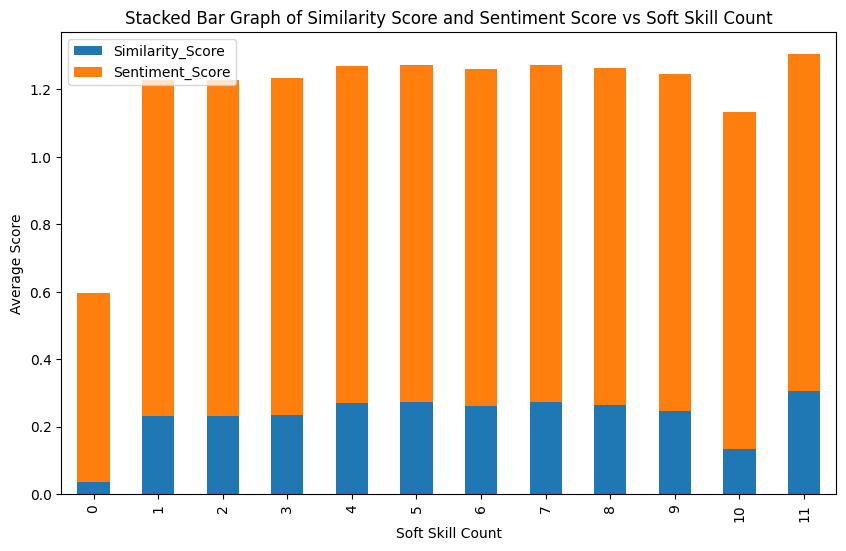

In [64]:
# prompt: give me stacked bar graph between soft skills on x axis and y axis similarity score and sentiment score

import matplotlib.pyplot as plt

# Assuming 'df_with_scores' is your DataFrame containing 'Soft_Skill_Count', 'Similarity_Score', and 'Sentiment_Score'

# Group by Soft_Skill_Count and get the mean of Similarity_Score and Sentiment_Score
grouped_data = df_with_scores.groupby('Soft_Skill_Count')[['Similarity_Score', 'Sentiment_Score']].mean()

# Create a stacked bar graph
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set labels and title
plt.xlabel('Soft Skill Count')
plt.ylabel('Average Score')
plt.title('Stacked Bar Graph of Similarity Score and Sentiment Score vs Soft Skill Count')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.show()


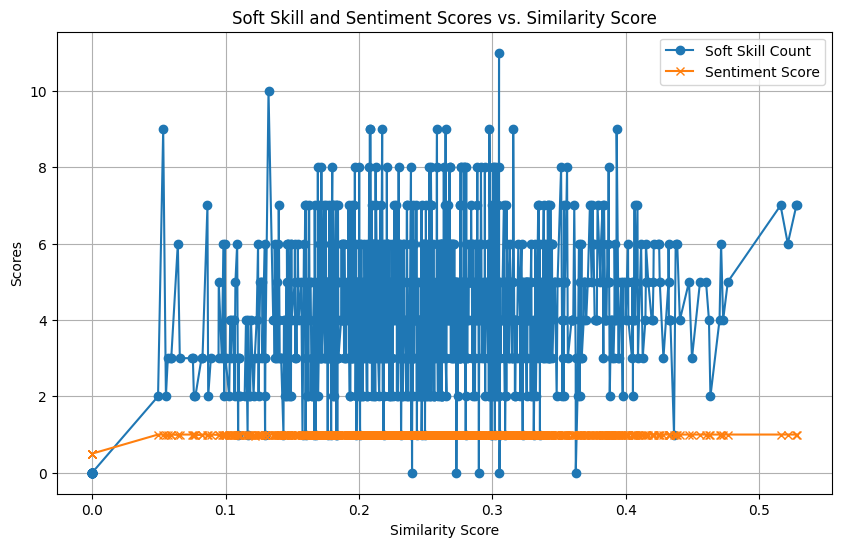

In [67]:
# prompt: give me double line graph for similarity score on x axis and y axis soft skills and sentiment score  the lines connect to continuos increasing x with y

import matplotlib.pyplot as plt

# Assuming df_with_scores is your DataFrame
# Sort the DataFrame by Similarity_Score in ascending order
df_sorted = df_with_scores.sort_values('Similarity_Score')

# Extract the relevant columns
similarity_scores = df_sorted['Similarity_Score']
soft_skill_scores = df_sorted['Soft_Skill_Count']
sentiment_scores = df_sorted['Sentiment_Score']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(similarity_scores, soft_skill_scores, label='Soft Skill Count', marker='o')
plt.plot(similarity_scores, sentiment_scores, label='Sentiment Score', marker='x')

# Add labels and title
plt.xlabel('Similarity Score')
plt.ylabel('Scores')
plt.title('Soft Skill and Sentiment Scores vs. Similarity Score')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


#Score prediction model

In [68]:
# prompt: i want to convert /content/df1_normalized.csv to a df

df_normalized = pd.read_csv('/content/df1_normalized.csv')
print(df_normalized.head())

    ID  Number_of_Jobs  Number_of_Adjectives  Number_of_Degrees  \
0  649               3                    43                  1   
1  160               4                   102                  2   
2  369               4                    52                  0   
3  742               2                   106                  1   
4  465               3                    37                  0   

   Number_of_Certificates  Years_of_Experience  Soft skill count  \
0                       0                   12                 6   
1                       0                   12                 9   
2                       1                   38                 4   
3                       4                    3                 8   
4                       3                   15                 4   

   Technical skill count Risk_Category  Weighted_Score_Normalized  
0                      1   Maybe Risky                  15.820584  
1                      3         Risky              

In [69]:
# prompt: i want numerical data only and convert others to encoding

from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame to avoid modifying the original
df_encoded = df_normalized.copy()

# Iterate through columns and apply Label Encoding to non-numerical columns
for column in df_encoded.columns:
    if not pd.api.types.is_numeric_dtype(df_encoded[column]):
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df_encoded[column])

# Now, df_encoded contains only numerical data with categorical features encoded
print(df_encoded.head())


    ID  Number_of_Jobs  Number_of_Adjectives  Number_of_Degrees  \
0  649               3                    43                  1   
1  160               4                   102                  2   
2  369               4                    52                  0   
3  742               2                   106                  1   
4  465               3                    37                  0   

   Number_of_Certificates  Years_of_Experience  Soft skill count  \
0                       0                   12                 6   
1                       0                   12                 9   
2                       1                   38                 4   
3                       4                    3                 8   
4                       3                   15                 4   

   Technical skill count  Risk_Category  Weighted_Score_Normalized  
0                      1              0                  15.820584  
1                      3              2           

Accuracy for Risk Prediction: 0.985
Mean Squared Error for Weighted Score Prediction: 3.5070850944268477


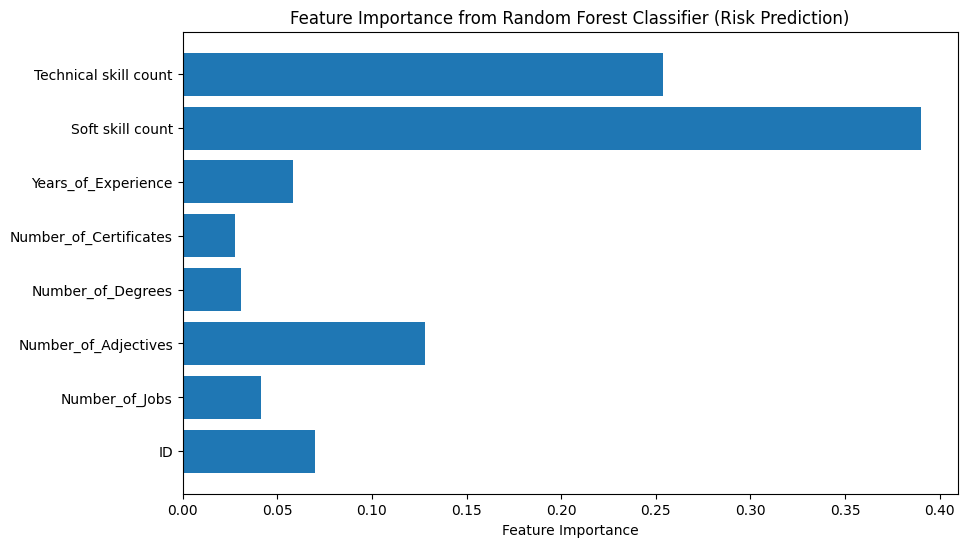

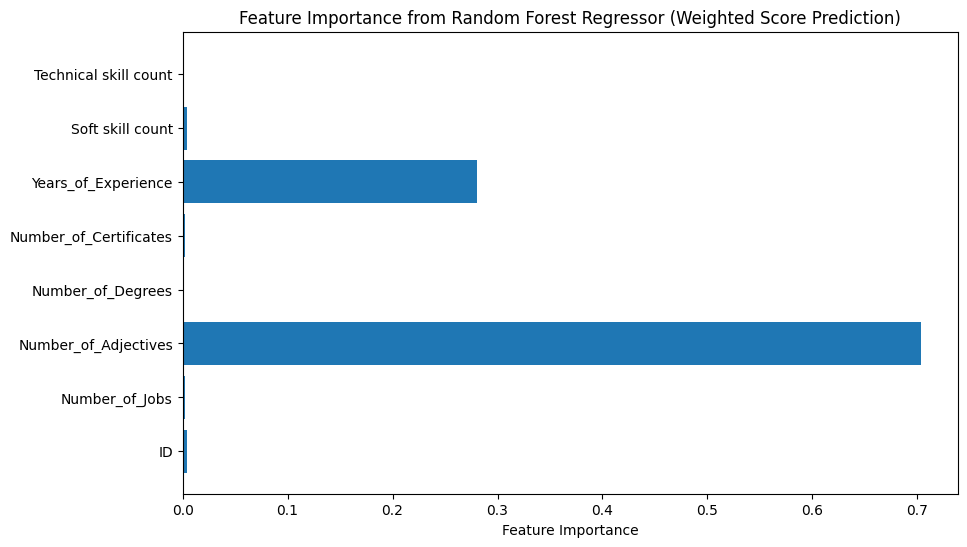

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Assuming df_encoded is your DataFrame with encoded features
# Normalize the 'Number_of_adjective' column
scaler = MinMaxScaler()
df_encoded['Number_of_Adjectives'] = scaler.fit_transform(df_encoded[['Number_of_Adjectives']])

# Define your features (X) and target variables (y_risk and y_weighted_score)
X = df_encoded.drop(['Risk_Category', 'Weighted_Score_Normalized'], axis=1)  # Replace with actual column names
y_risk = df_encoded['Risk_Category']  # Replace with the actual target column name for risk
y_weighted_score = df_encoded['Weighted_Score_Normalized']  # Replace with the actual target column name for weighted score

# Select the first 1000 samples for training
X = X[:1000]
y_risk = y_risk[:1000]
y_weighted_score = y_weighted_score[:1000]

# Split the data into training and testing sets
X_train, X_test, y_risk_train, y_risk_test, y_weighted_score_train, y_weighted_score_test = train_test_split(
    X, y_risk, y_weighted_score, test_size=0.2, random_state=42
)

# Scale the features (optional, but good practice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define base learners for the stacking classifier (using regressors for weighted score prediction)
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),  # Change to Regressor
    ('knn', KNeighborsRegressor(n_neighbors=5)),  # Change to Regressor
    ('dt', DecisionTreeRegressor(random_state=42))  # Change to Regressor
]

# Create stacking classifier for risk prediction
stacking_classifier_risk = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('dt', DecisionTreeClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)

# Train the stacking classifier for risk prediction
stacking_classifier_risk.fit(X_train, y_risk_train)

# Make predictions on the test set for risk
y_risk_pred = stacking_classifier_risk.predict(X_test)

# Evaluate the accuracy for risk prediction
accuracy_risk = accuracy_score(y_risk_test, y_risk_pred)
print(f"Accuracy for Risk Prediction: {accuracy_risk}")

# Create stacking regressor for weighted score prediction
stacking_regressor_weighted_score = StackingRegressor(
    estimators=base_learners,
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

# Train the stacking regressor for weighted score prediction
stacking_regressor_weighted_score.fit(X_train, y_weighted_score_train)

# Make predictions on the test set for weighted score
y_weighted_score_pred = stacking_regressor_weighted_score.predict(X_test)

# Round the predicted weighted scores
y_weighted_score_pred_rounded = np.round(y_weighted_score_pred)

# Evaluate the performance for weighted score prediction (e.g., using Mean Squared Error)
mse_weighted_score = mean_squared_error(y_weighted_score_test, y_weighted_score_pred_rounded)
print(f"Mean Squared Error for Weighted Score Prediction: {mse_weighted_score}")

# Plotting feature importance for Random Forest Classifier (Risk Prediction)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_risk_train)

# Extract feature importances
importances_classifier = rf_classifier.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_classifier)), importances_classifier, align='center')
plt.yticks(range(len(importances_classifier)), X.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier (Risk Prediction)')
plt.show()

# Plotting feature importance for Random Forest Regressor (Weighted Score Prediction)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_weighted_score_train)

# Extract feature importances
importances_regressor = rf_regressor.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_regressor)), importances_regressor, align='center')
plt.yticks(range(len(importances_regressor)), X.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Regressor (Weighted Score Prediction)')
plt.show()
